In [416]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV


In [417]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

Загрузка данных

In [418]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [419]:
test = pd.read_csv(TEST_DATASET_PATH)

Рапределение целевой переменной

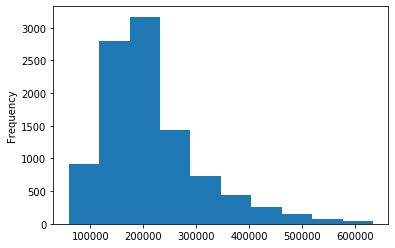

In [420]:
train['Price'].plot( kind='hist', logx=False) 

Ковариация

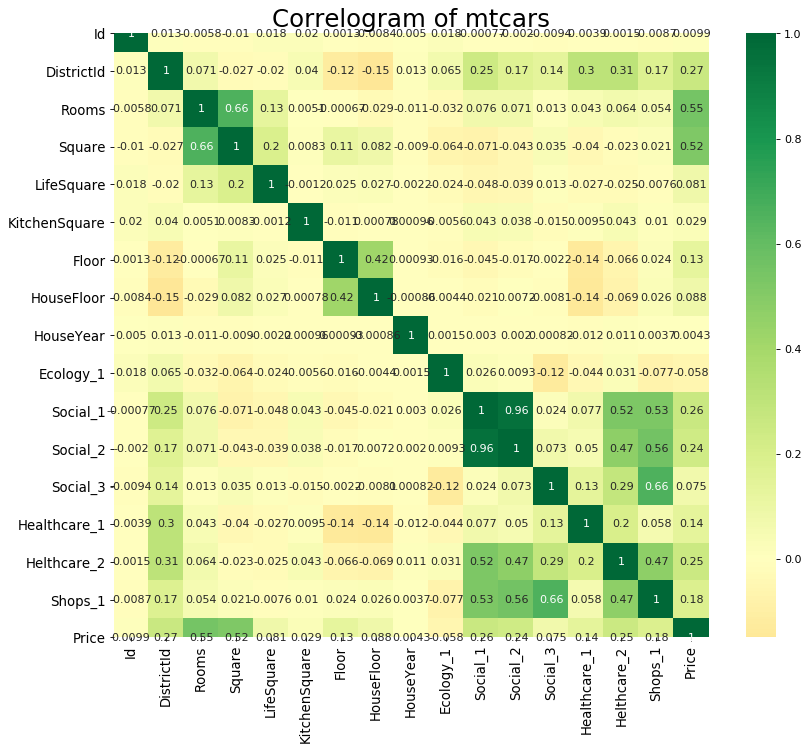

In [421]:
corr = train.corr()
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Отметим, что некоторые признаки скоррелированы больше 0.5. 

Почистим данные.

In [422]:
X = train.copy()


del_index_row= X[(X['HouseYear'] < 0) | (X['Rooms']==0) |
                  (X['Square']< X['LifeSquare']) | 
                  (X['Floor'] > X['HouseFloor']) |
                (X['Square'] > 500) |
                 (X['Square'] < 0) |
                (X['LifeSquare'] > 500) |
                 (X['LifeSquare'] < 0) 
                 
                 
                ].index
X.drop(del_index_row, inplace=True)

X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
    

len(del_index_row)




2184

In [423]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [424]:


def del_feature(_X):
    _X.drop(['Id'], axis=1, inplace=True)
    #удалю Healthcare_1 как содержащую много пустых данных
    _X.drop(['Healthcare_1'], axis=1, inplace=True)
    #удалю LifeSquare так как корреляция с Square = 0.66
    _X.drop(['LifeSquare'], axis=1, inplace=True)
    #удалю как признаки с малым весом
    _X.drop(['Ecology_2'], axis=1, inplace=True)
    _X.drop(['Ecology_3'], axis=1, inplace=True)
    _X.drop(['Shops_2'], axis=1, inplace=True)
    

del_feature(X)
X.drop(['Price'], axis=1, inplace=True)
del_feature(test)


In [425]:
test.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,58,2.0,49.882643,6.0,6,14.0,1972,0.310199,11,2748,1,0,0
1,74,2.0,69.263183,1.0,6,1.0,1977,0.075779,6,1437,3,0,2
2,190,1.0,13.597819,12.0,2,5.0,1909,0.000000,30,7538,87,5,5
3,47,2.0,73.046609,9.0,22,22.0,2007,0.101872,23,4583,3,3,3
4,27,1.0,47.527111,1.0,17,17.0,2017,0.072158,2,629,1,0,0


In [426]:
y = train['Price']
y.drop(del_index_row, inplace=True)

In [427]:
X.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,35,2.0,47.981561,6.0,7,9.0,1969,0.089040,33,7976,5,0,11
1,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,46,10309,1,1,16
2,53,2.0,44.947953,0.0,8,12.0,1968,0.049637,34,7759,0,1,3
3,58,2.0,53.352981,9.0,8,17.0,1977,0.437885,23,5735,3,0,5
4,99,1.0,39.649192,7.0,11,12.0,1976,0.012339,35,5776,1,2,4


In [428]:
#from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()

colnames = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns=colnames)
colnames = test.columns
test = pd.DataFrame(scaler.fit_transform(test), columns=colnames)


In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,shuffle=True, random_state=21)

In [430]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [431]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.945
Test R2:	0.681


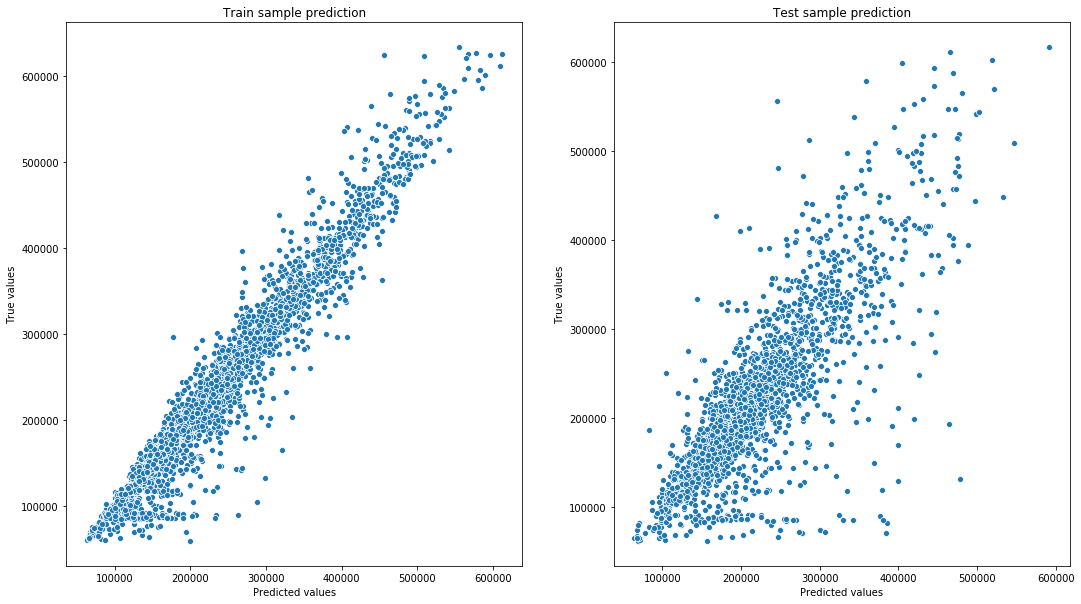

In [432]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Кроссвалидация

In [433]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.65110325, 0.66031522, 0.65335107])

Значимость признаков

In [434]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.423999
8,Social_1,0.094558
9,Social_2,0.080998
1,Rooms,0.075143
10,Social_3,0.058513
0,DistrictId,0.053319
6,HouseYear,0.046632
7,Ecology_1,0.045870
4,Floor,0.033741
3,KitchenSquare,0.031149


Формируем файл для проверки

In [435]:
test.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,0.152140,0.107333,-0.343979,0.002332,-0.480057,0.206083,-0.667299,1.585280,-0.794834,-0.660397,-0.304366,-0.891612,-0.888194
1,0.514336,0.107333,0.671194,-0.500230,-0.480057,-1.708911,-0.398066,-0.367283,-1.080052,-0.986014,-0.220549,-0.891612,-0.469511
2,3.140252,-1.085258,-2.244616,0.605406,-1.209627,-1.119682,-4.059632,-0.998468,0.288994,0.529306,3.299785,2.487242,0.158513
3,-0.096869,0.107333,0.869374,0.303869,2.438224,1.384540,1.217331,-0.149940,-0.110311,-0.204634,-0.220549,1.135700,-0.260169
4,-0.549613,-1.085258,-0.467364,-0.500230,1.526261,0.648004,1.755796,-0.397445,-1.308227,-1.186699,-0.304366,-0.891612,-0.888194


In [436]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [437]:
predictions = rf_model.predict(test)
predictions

array([185451.98736242, 192731.20648877, 199502.28624137, ...,
       232028.50549164, 188947.50387199, 304236.46533359])

In [438]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,185451.987362
1,15856,192731.206489
2,5480,199502.286241
3,15664,327602.173373
4,14275,138905.316444


In [439]:
submit.to_csv('rf_submit.csv', index=False)